# Epidemiology Dataframes

### psycopg2  - Library to connect PostgreSQL with Python
### pandas - Python Data Analysis Library

In [92]:
import pandas as pd
import matplotlib.patches as mpatches
import numpy as np
import matplotlib as plt
#import plotly
#import plotly.plotly as py
#import plotly.graph_objs as go
plt.rcParams["figure.figsize"] = "21, 10"
plt.rcParams.update({'font.size': 15})
from pandas.core import datetools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils import check_array

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#plotly.tools.set_credentials_file(username='QiqeMtz', api_key='kCwnrGAARunz82cP5VkK')

### Mean Absolute Percentage Error - Function def

In [4]:
# First function http://glowingpython.blogspot.com.co/2015/01/forecasting-beer-consumption-with.html
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return float(100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx]))

In [5]:
# Second function https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
#a = actual
def mean_absolute_percentage_error(b, a): 
    mask = a != 0
    return ((np.fabs(a[mask] - b[mask])/a[mask]).mean())*100


In [93]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

series = pd.read_csv('rips_rmcab_surveillance_09_14.csv', index_col='Start_Date', parse_dates=['Start_Date'], squeeze=True, date_parser=dateparse)
C1 = pd.read_csv('C1_exp_pred.csv', index_col='Date', parse_dates=['Date'], squeeze=True, date_parser=dateparse)
C2 = pd.read_csv('C2_exp_pred.csv', index_col='Date', parse_dates=['Date'], squeeze=True, date_parser=dateparse)
C3 = pd.read_csv('C3_exp_pred.csv', index_col='Date', parse_dates=['Date'], squeeze=True, date_parser=dateparse)
IRA_MONTHLY_DX = pd.read_csv("ira_monthly_dx_09_14.csv", index_col='FECHA', parse_dates=['FECHA'], date_parser=dateparse)
IRA_WEEKLY_DX = pd.read_csv("ira_weekly_dx_09_14.csv", index_col='FECHA', parse_dates=['FECHA'], date_parser=dateparse)

#print(series.head())


#series
#series['Casos'].plot()
#plt.pyplot.show()


#series.dtypes
series['Casos'] = series['Casos'].astype(np.float64)
#series.dtypes

#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
#data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)

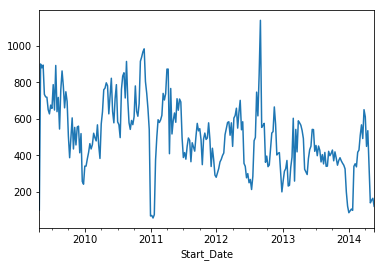

In [7]:
# series = pd.read_csv('rips_rmcab_surveillance_09_14.csv', index_col='Start_Date', parse_dates=['Start_Date'], squeeze=True, date_parser=dateparse)
series['Casos'].plot()
plt.pyplot.show()

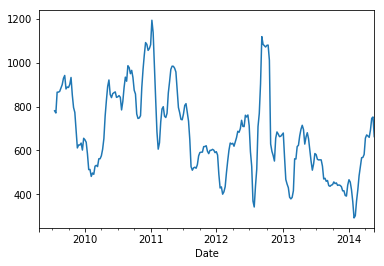

In [8]:
C1['upperbound'].plot()
plt.pyplot.show()

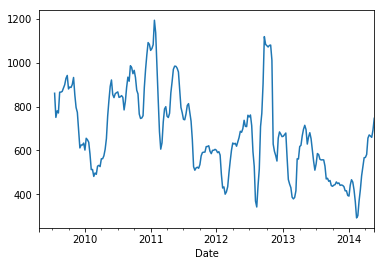

In [9]:
C2['upperbound'].plot()
plt.pyplot.show()

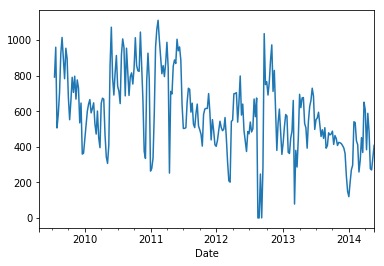

In [10]:
C3['upperbound'].plot()
plt.pyplot.show()

### Test para verificar si la serie de tiempo tiene comportamiento estacionario

In [11]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = pd.Series.rolling(timeseries, window=52,center=False).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = pd.Series.rolling(timeseries, window=52,center=False).std()
    
    #Plot rolling statistics:
    fig = plt.pyplot.figure(figsize=(12, 8))
    orig = plt.pyplot.plot(timeseries, color='blue',label='Original')
    mean = plt.pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.pyplot.plot(rolstd, color='black', label = 'Rolling Std')
    plt.pyplot.legend(loc='best')
    plt.pyplot.title('Rolling Mean & Standard Deviation')
    plt.pyplot.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    #dftest = adfuller(timeseries, maxlag=12, autolag=None, regression='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

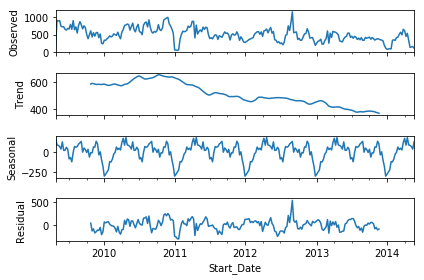

In [12]:
decomposition = seasonal_decompose(series['Casos'], freq=52)  
fig = plt.pyplot.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

decomposition.plot()

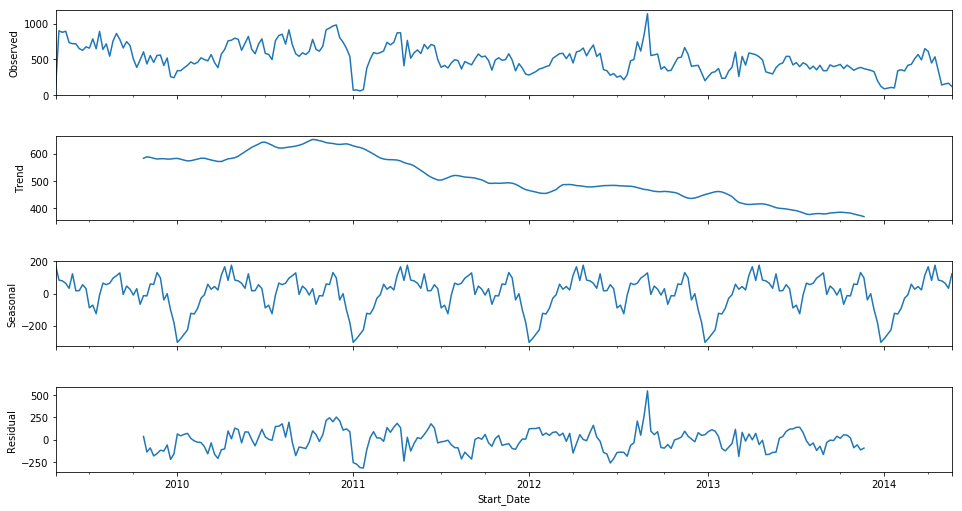

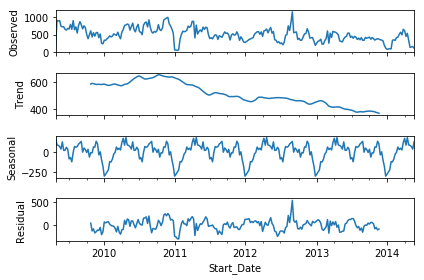

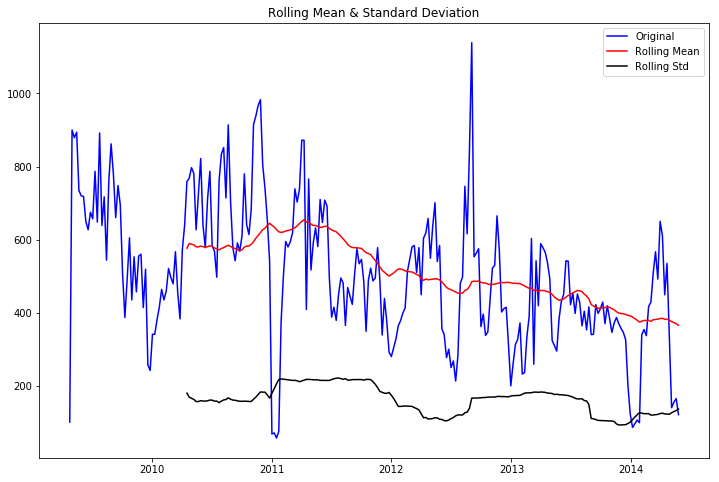

Results of Dickey-Fuller Test:
Test Statistic                  -5.041866
p-value                          0.000018
#Lags Used                       3.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


In [13]:
test_stationarity(series['Casos'])

# if the ‘Test Statistic’ is greater than the ‘Critical Value’ then the time series is stationary.

# The ARI time series is non-seasonal

## Se obtienen los casos y el tamaño de las muestras

In [95]:
# X tiene todos los valores Fecha -  Numero de Casos (364 en total) de inicio a fin
X = series['Casos']

# size almacena el valor 240, equivale al 66.66% de todos los valores (66.6% de 364) 
size = int(len(X) * 0.66)

## ARIMA

In [96]:


# train [fecha, casos] tiene desde el valor 101 al 411 (240 valores) que van desde el 2009-04-26 al 2013-10-25
# y va desde 0 a size (240)
# test almacena los datos [fecha, casos] desde el valor 344 al 268 (124 valores) que van desde el 2013-11-01 al 2016-03-28
# y va desde size(240) a len(X) (364)
train_a, test_a = X[0:size], X[size:len(X)]

# history almacena la lista de 364 valores (todos) [101-268], sin considerar la fecha, solo una lista de numeros (casos)
history_a = [x for x in train_a]

# predictions es una lista donde se hara un append de los valores predichos
ARIMA_predictions = list()
ARIMA_predictions_date = list()

In [104]:

# ciclo desde 0 a 123

for t in range(len(test_a)):
    
    # al modelo se le agrega la serie history con todos los valores (364)
    # order=(p,q,d) are the AR order, the degree of differencing, and the MA order.
    
	ARIMA_model = ARIMA(history_a, order=(5,1,0))
    
    #ajusta el modelo ARIMA en base a los parametros (p,d,q)
	ARIMA_model_fit = ARIMA_model.fit(disp=0)
    
    # output almacena el valor predecido con la funcion forecast() [one step]
    # Con history cargado y actualizado en cada iteracion, el modelo se ajusta y predice el siguiente valor
	output = ARIMA_model_fit.forecast()
    
    #se guarda en output el cual es un array y posteriormente se almacena en yhat
	yhat = output[0]
    
    # el valor predecido se almacena en la lista de predicciones
	ARIMA_predictions.append(yhat)
    
    # en obs se guarda el valor que esta dentro de test en la posicion t
	obs = test_a[t]
	dates = test_a.index[t]
	ARIMA_predictions_date.append(dates)
    
    # se concatena a history para en la siguiente iteracion re-ajustar el modelo
	history_a.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
#error = mean_squared_error(test, ARIMA_predictions)
#real_error = np.sqrt(error)
#print('Test MSE: %.3f' % real_error)

predicted=759.650062, expected=1139.000000
predicted=1096.450226, expected=553.000000
predicted=687.914515, expected=563.000000
predicted=577.005869, expected=575.000000
predicted=543.486010, expected=362.000000
predicted=417.596383, expected=396.000000
predicted=463.839877, expected=338.000000
predicted=345.061900, expected=347.000000
predicted=357.880759, expected=438.000000
predicted=434.609160, expected=522.000000
predicted=503.119276, expected=530.000000
predicted=536.202480, expected=665.000000
predicted=631.651732, expected=571.000000
predicted=578.973392, expected=402.000000
predicted=435.953223, expected=411.000000
predicted=399.300744, expected=415.000000
predicted=403.169136, expected=311.000000
predicted=358.151308, expected=200.000000
predicted=243.919807, expected=260.000000
predicted=243.723922, expected=313.000000
predicted=303.418563, expected=327.000000
predicted=342.858528, expected=372.000000
predicted=371.962634, expected=232.000000
predicted=252.812222, expected=2

# SARIMAX

In [105]:
len(history_a)

266

In [97]:

# train [fecha, casos] tiene desde el valor 101 al 411 (240 valores) que van desde el 2009-04-26 al 2013-10-25
# y va desde 0 a size (240)
# test almacena los datos [fecha, casos] desde el valor 344 al 268 (124 valores) que van desde el 2013-11-01 al 2016-03-28
# y va desde size(240) a len(X) (364)
train_s, test_s = X[0:size], X[size:len(X)]

# history almacena la lista de 364 valores (todos) [101-268], sin considerar la fecha, solo una lista de numeros (casos)
history_s = [x for x in train_s]

# predictions es una lista donde se hara un append de los valores predichos
SARIMAX_predictions = list()
SARIMAX_predictions_date = list()

In [106]:
for t in range(len(test_s)):
    # al modelo se le agrega la serie history con todos los valores (364)
    # order=(p,q,d) are the AR order, the degree of differencing, and the MA order.
#	SARIMAX_model = SARIMAX(history, order=(5,0,0), trend='n')
	SARIMAX_model = SARIMAX(history_s, order=(5,1,0))
#	SARIMAX_model = SARIMAX(history, order=(5,0,0), seasonal_order=(5,0,0,4), trend='n')
    #ajusta el modelo ARIMA en base a los parametros (p,q,d)
	SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
    # output almacena el valor predecido con la funcion forecast() [one step]
    # Con history cargado y actualizado en cada iteracion, el modelo se ajusta y predice el siguiente valor
	output = SARIMAX_model_fit.forecast()
    #se guarda en output el cual es un array y posteriormente se almacena en yhat
	yhat = output[0]
    # el valor predecido se almacena en la lista de predicciones
	SARIMAX_predictions.append(yhat)
    # en obs se guarda el valor que esta dentro de test en la posicion t
	obs = test_s[t]
	dates = test_s.index[t]
	SARIMAX_predictions_date.append(dates)
    # se concatena a history para en la siguiente iteracion re-ajustar el modelo
	history_s.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
#error = mean_squared_error(test, SARIMAX_predictions)
#real_error = np.sqrt(error)
#print('Test MSE: %.3f' % real_error)

predicted=755.951218, expected=1139.000000
predicted=1090.683219, expected=553.000000
predicted=683.856894, expected=563.000000
predicted=574.401388, expected=575.000000
predicted=541.148204, expected=362.000000
predicted=416.174420, expected=396.000000
predicted=462.628422, expected=338.000000
predicted=344.485256, expected=347.000000
predicted=357.444273, expected=438.000000
predicted=433.789219, expected=522.000000
predicted=501.804221, expected=530.000000
predicted=534.598454, expected=665.000000
predicted=629.367499, expected=571.000000
predicted=576.811849, expected=402.000000
predicted=434.707634, expected=411.000000
predicted=398.385606, expected=415.000000
predicted=402.297220, expected=311.000000
predicted=357.631908, expected=200.000000
predicted=244.058074, expected=260.000000
predicted=244.010718, expected=313.000000
predicted=303.445922, expected=327.000000
predicted=342.718907, expected=372.000000
predicted=371.634910, expected=232.000000
predicted=252.996981, expected=2

## CREACION DE DATAFRAMES PARA POSTERIOR GRAFICACIÓN

In [109]:
l

91

In [110]:
# Aqui se necesita convertir a serie de tiempo, para lograr tener fechas y valores predecidos de ARIMA
ARIMA = pd.DataFrame({'Date':ARIMA_predictions_date, 'Predicted':ARIMA_predictions, 'Expected': test_a})
C1_muestra, C2_muestra, C3_muestra = C1[size:len(C1)], C2[size:len(C2)], C3[size:len(C3)]
SARIMAX = pd.DataFrame({'Date':SARIMAX_predictions_date, 'Predicted':SARIMAX_predictions, 'Expected': test_s})

J00X_DT = IRA_MONTHLY_DX.loc[IRA_MONTHLY_DX['COD_DX'] == 'J00X']
J069_DT = IRA_MONTHLY_DX.loc[IRA_MONTHLY_DX['COD_DX'] == 'J069']
J029_DT = IRA_MONTHLY_DX.loc[IRA_MONTHLY_DX['COD_DX'] == 'J029']
J039_DT = IRA_MONTHLY_DX.loc[IRA_MONTHLY_DX['COD_DX'] == 'J039']
J209_DT = IRA_MONTHLY_DX.loc[IRA_MONTHLY_DX['COD_DX'] == 'J209']
J068_DT = IRA_MONTHLY_DX.loc[IRA_MONTHLY_DX['COD_DX'] == 'J068']
J219_DT = IRA_MONTHLY_DX.loc[IRA_MONTHLY_DX['COD_DX'] == 'J219']
J019_DT = IRA_MONTHLY_DX.loc[IRA_MONTHLY_DX['COD_DX'] == 'J019']

W_J00X_DT = IRA_WEEKLY_DX.loc[IRA_WEEKLY_DX['COD_DX'] == 'J00X']
W_J069_DT = IRA_WEEKLY_DX.loc[IRA_WEEKLY_DX['COD_DX'] == 'J069']
W_J029_DT = IRA_WEEKLY_DX.loc[IRA_WEEKLY_DX['COD_DX'] == 'J029']
W_J039_DT = IRA_WEEKLY_DX.loc[IRA_WEEKLY_DX['COD_DX'] == 'J039']
W_J209_DT = IRA_WEEKLY_DX.loc[IRA_WEEKLY_DX['COD_DX'] == 'J209']
W_J068_DT = IRA_WEEKLY_DX.loc[IRA_WEEKLY_DX['COD_DX'] == 'J068']
W_J219_DT = IRA_WEEKLY_DX.loc[IRA_WEEKLY_DX['COD_DX'] == 'J219']
W_J019_DT = IRA_WEEKLY_DX.loc[IRA_WEEKLY_DX['COD_DX'] == 'J019']

IRA_MONTHLY_GROUP = pd.DataFrame(IRA_MONTHLY_DX.groupby('COD_DX').sum())
#IRA_MONTHLY_GROUP

# GRAFICACIÓN

## PIE CHART - IRA MONTHLY DX

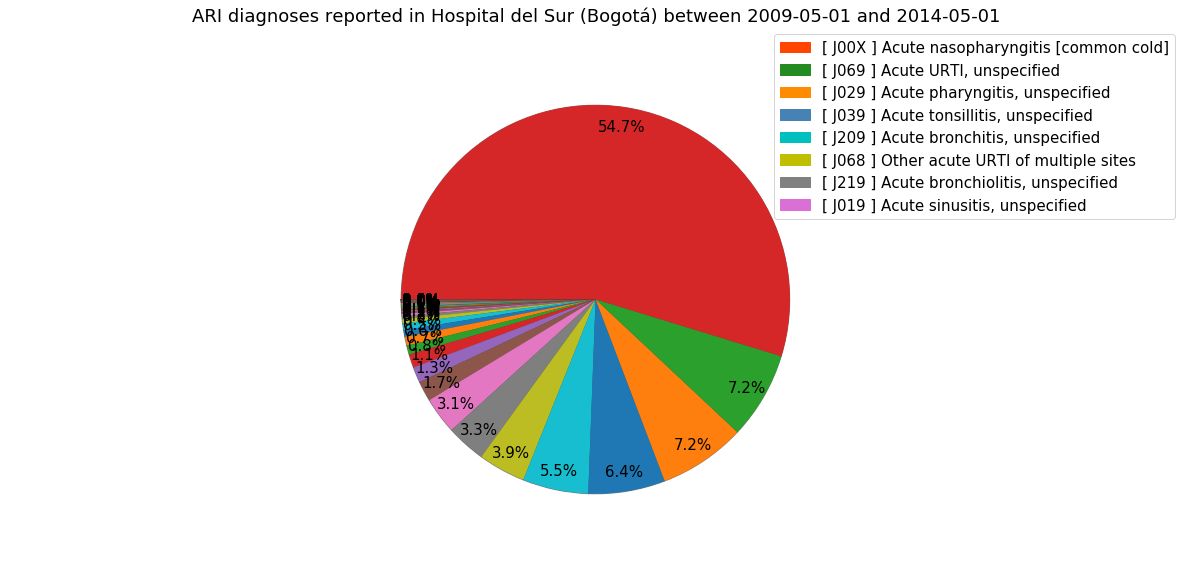

In [111]:
#labels = list(IRA_MONTHLY_GROUP.index)
labels = 'J00X', 'J069', 'J029', 'J039', 'J209', 'J068', 'J219', 'J019'
sizes = [sum(J00X_DT['TOTAL']), sum(J069_DT['TOTAL']), sum(J029_DT['TOTAL']), sum(J039_DT['TOTAL']), sum(J209_DT['TOTAL']), sum(J068_DT['TOTAL']), sum(J219_DT['TOTAL']), sum(J019_DT['TOTAL'])]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors_ax = 'cyan', 'red', 'green', 'orange', 'purple', 'pink', 'brown', 'gray'
fig1 = plt.pyplot.figure()
ax1 = fig1.add_subplot(111)
#fig1, ax1 = plt.pyplot.subplots()
ax1.pie(sorted(IRA_MONTHLY_GROUP['TOTAL']), autopct='%1.1f%%',
        shadow=True, startangle=180, pctdistance=0.9, labeldistance=1.2, radius=20)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

J00X_legend = mpatches.Patch(color='orangered', label='[ J00X ] Acute nasopharyngitis [common cold]')
J069_legend = mpatches.Patch(color='forestgreen', label='[ J069 ] Acute URTI, unspecified')
J029_legend = mpatches.Patch(color='darkorange', label='[ J029 ] Acute pharyngitis, unspecified')
J039_legend = mpatches.Patch(color='steelblue', label='[ J039 ] Acute tonsillitis, unspecified')
J209_legend = mpatches.Patch(color='c', label='[ J209 ] Acute bronchitis, unspecified')
J068_legend = mpatches.Patch(color='y', label='[ J068 ] Other acute URTI of multiple sites')
J219_legend = mpatches.Patch(color='gray', label='[ J219 ] Acute bronchiolitis, unspecified')
J019_legend = mpatches.Patch(color='orchid', label='[ J019 ] Acute sinusitis, unspecified')
plt.pyplot.legend(handles=[J00X_legend, J069_legend, J029_legend, J039_legend, J209_legend, J068_legend, J219_legend, J019_legend])
#plt.pyplot.legend(labels, loc='best')
plt.pyplot.title('ARI diagnoses reported in Hospital del Sur (Bogotá) between 2009-05-01 and 2014-05-01')
plt.pyplot.margins(1.0, 0)
plt.pyplot.savefig('ARI_diagnoses_pie.eps', format='eps', dpi=2000)
plt.pyplot.show()

labels = 'J00X', 'J069', 'J029', 'J039', 'J209', 'J068', 'J219', 'J019'
sizes = [sum(J00X_DT['TOTAL']), sum(J069_DT['TOTAL']), sum(J029_DT['TOTAL']), sum(J039_DT['TOTAL']), sum(J209_DT['TOTAL']), sum(J068_DT['TOTAL']), sum(J219_DT['TOTAL']), sum(J019_DT['TOTAL'])]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors_ax = 'cyan', 'red', 'green', 'orange', 'purple', 'pink', 'brown', 'gray'
fig1, ax1 = plt.pyplot.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors_ax, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

J00X_legend = mpatches.Patch(color='cyan', label='[ J00X ] Acute nasopharyngitis [common cold]')
J069_legend = mpatches.Patch(color='red', label='[ J069 ] Acute URTI, unspecified')
J029_legend = mpatches.Patch(color='green', label='[ J029 ] Acute pharyngitis, unspecified')
J039_legend = mpatches.Patch(color='orange', label='[ J039 ] Acute tonsillitis, unspecified')
J209_legend = mpatches.Patch(color='purple', label='[ J209 ] Acute bronchitis, unspecified')
J068_legend = mpatches.Patch(color='pink', label='[ J068 ] Other acute URTI of multiple sites')
J219_legend = mpatches.Patch(color='brown', label='[ J219 ] Acute bronchiolitis, unspecified')
J019_legend = mpatches.Patch(color='gray', label='[ J019 ] Acute sinusitis, unspecified')
plt.pyplot.legend(handles=[J00X_legend, J069_legend, J029_legend, J039_legend, J209_legend, J068_legend, J219_legend, J019_legend])

plt.pyplot.title('ARI diagnoses reported in Hospital del Sur (Bogotá) between 2009-05-01 and 2014-05-01')
plt.pyplot.margins(1.0, 0)
plt.pyplot.savefig('ARI_diagnoses_pie.eps', format='eps', dpi=1000)
plt.pyplot.show()

## IRA WEEKLY DX

In [60]:
#Configuration to line charts

plt.rcParams["figure.figsize"] = "25, 10"
plt.rcParams.update({'font.size': 18})

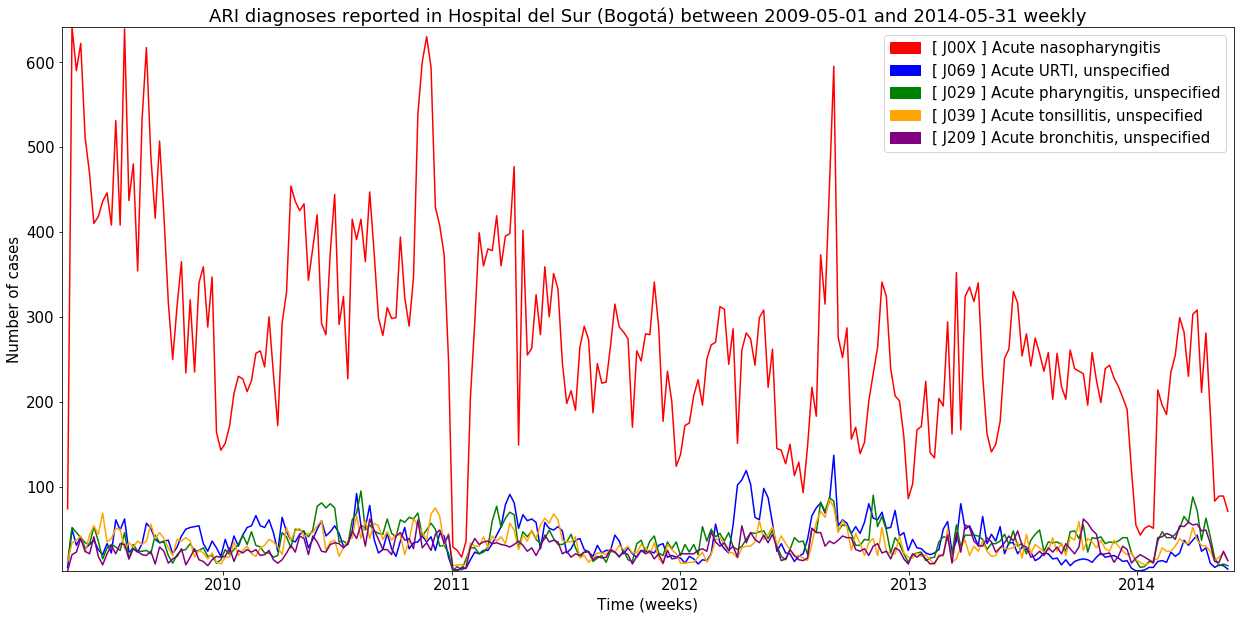

In [112]:
W_J00X, = plt.pyplot.plot(W_J00X_DT['TOTAL'], color='red')
W_J069, = plt.pyplot.plot(W_J069_DT['TOTAL'], color='blue')
W_J029, = plt.pyplot.plot(W_J029_DT['TOTAL'], color='green')
W_J039, = plt.pyplot.plot(W_J039_DT['TOTAL'], color='orange')
W_J209, = plt.pyplot.plot(W_J209_DT['TOTAL'], color='purple')

w_J00X_legend = mpatches.Patch(color='red', label='[ J00X ] Acute nasopharyngitis')
w_J069_legend = mpatches.Patch(color='blue', label='[ J069 ] Acute URTI, unspecified')
w_J029_legend = mpatches.Patch(color='green', label='[ J029 ] Acute pharyngitis, unspecified')
w_J039_legend = mpatches.Patch(color='orange', label='[ J039 ] Acute tonsillitis, unspecified')
w_J209_legend = mpatches.Patch(color='purple', label='[ J209 ] Acute bronchitis, unspecified')
plt.pyplot.legend(handles=[w_J00X_legend, w_J069_legend, w_J029_legend, w_J039_legend, w_J209_legend])

plt.pyplot.xlabel('Time (weeks)')
plt.pyplot.ylabel('Number of cases')
plt.pyplot.title('ARI diagnoses reported in Hospital del Sur (Bogotá) between 2009-05-01 and 2014-05-31 weekly')

plt.pyplot.margins(0.005, 0)
plt.pyplot.savefig('ARI_diagnoses_weekly.eps', format='eps', dpi=1000)
plt.pyplot.show()

## IRA Monthly DX

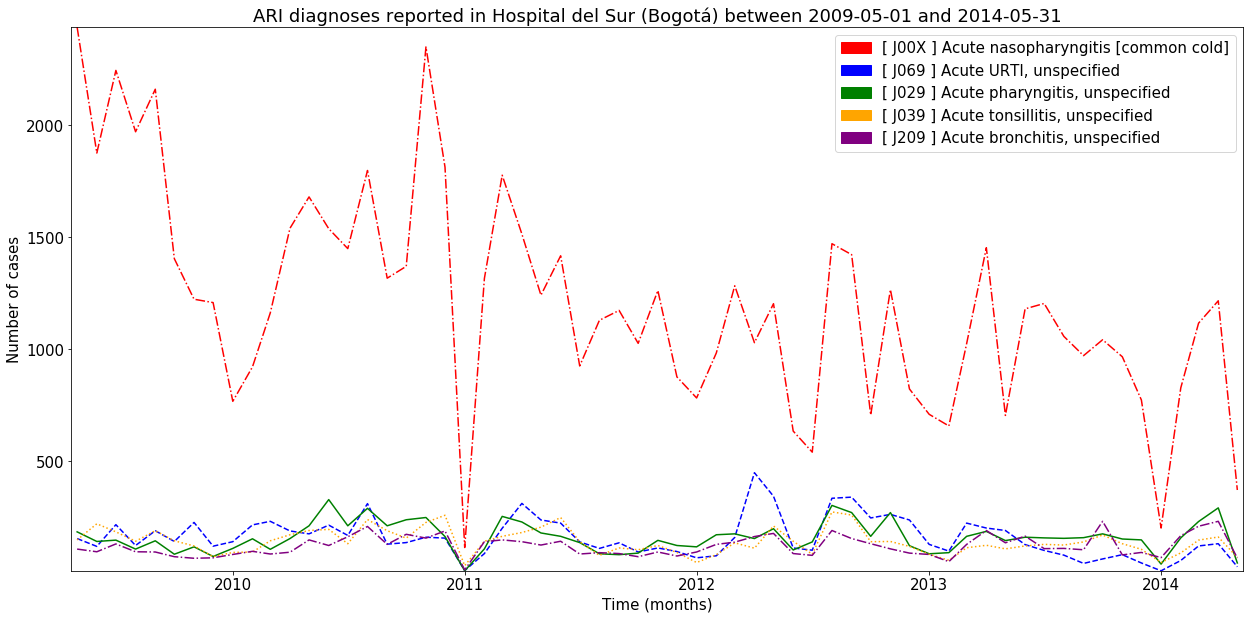

In [113]:
J00X, = plt.pyplot.plot(J00X_DT['TOTAL'], color='red', linestyle='-.')
J069, = plt.pyplot.plot(J069_DT['TOTAL'], color='blue', linestyle='--')
J029, = plt.pyplot.plot(J029_DT['TOTAL'], color='green', linestyle='-')
J039, = plt.pyplot.plot(J039_DT['TOTAL'], color='orange', linestyle=':')
J209, = plt.pyplot.plot(J209_DT['TOTAL'], color='purple', linestyle='-.')

J00X_legend = mpatches.Patch(color='red', label='[ J00X ] Acute nasopharyngitis [common cold]')
J069_legend = mpatches.Patch(color='blue', label='[ J069 ] Acute URTI, unspecified')
J029_legend = mpatches.Patch(color='green', label='[ J029 ] Acute pharyngitis, unspecified')
J039_legend = mpatches.Patch(color='orange', label='[ J039 ] Acute tonsillitis, unspecified')
J209_legend = mpatches.Patch(color='purple', label='[ J209 ] Acute bronchitis, unspecified')
plt.pyplot.legend(handles=[J00X_legend, J069_legend, J029_legend, J039_legend, J209_legend])

plt.pyplot.xlabel('Time (months)')
plt.pyplot.ylabel('Number of cases')
plt.pyplot.title('ARI diagnoses reported in Hospital del Sur (Bogotá) between 2009-05-01 and 2014-05-31')

plt.pyplot.margins(0.005, 0)
plt.pyplot.savefig('ARI_diagnoses.eps', format='eps', dpi=1000)
plt.pyplot.show()

## ARIMA VS ORIGINAL VALUES

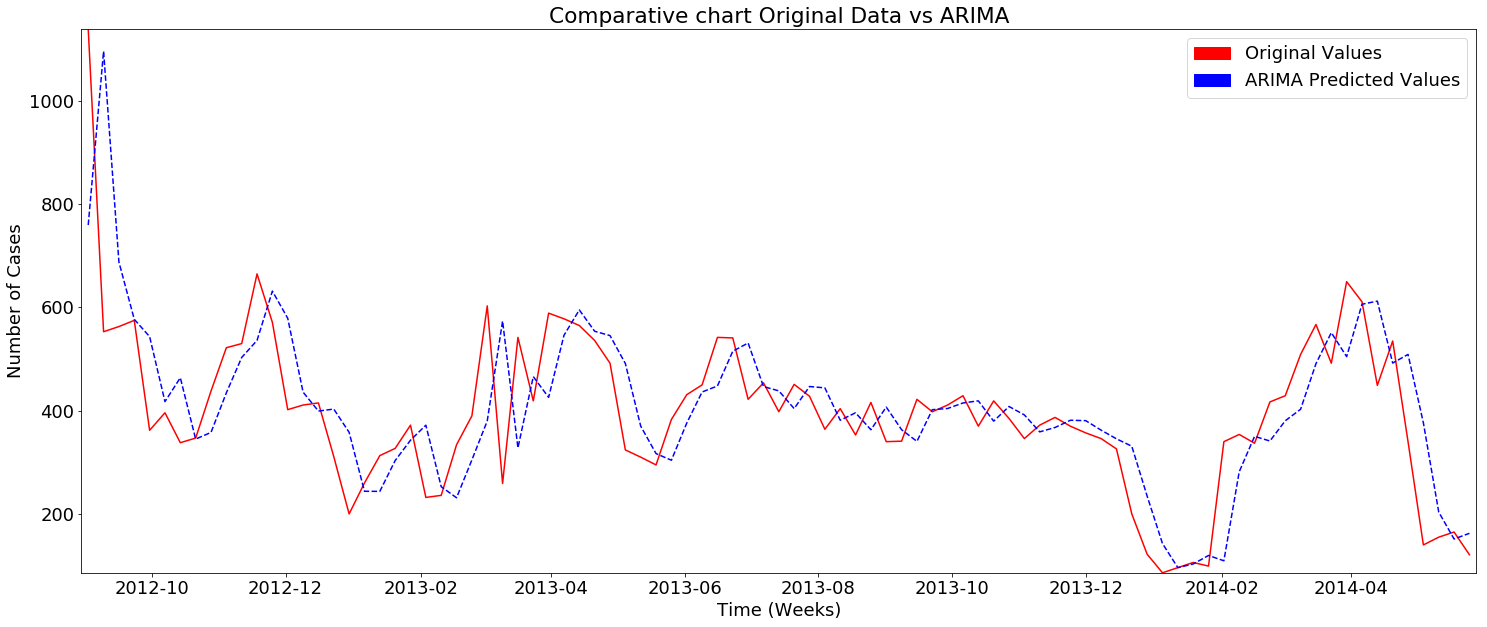

In [63]:
#Ploteo
ARIMA_expected, = plt.pyplot.plot(ARIMA['Expected'], label="Original Values", color="red")
ARIMA_predicted, = plt.pyplot.plot(ARIMA['Predicted'], label="Predicted ARIMA Values", color='blue', linestyle='--')

original_legend = mpatches.Patch(color='red', label='Original Values')
ARIMA_legend = mpatches.Patch(color='blue', label='ARIMA Predicted Values')
plt.pyplot.legend(handles=[original_legend, ARIMA_legend])

plt.pyplot.xlabel('Time (Weeks)')
plt.pyplot.ylabel('Number of Cases')
plt.pyplot.title('Comparative chart Original Data vs ARIMA')

plt.pyplot.margins(0.005, 0)
plt.pyplot.savefig('ARIMA_VS_ORIGINAL.eps', format='eps', dpi=1000)
plt.pyplot.show()

## SARIMAX VS ORIGINAL VALUES

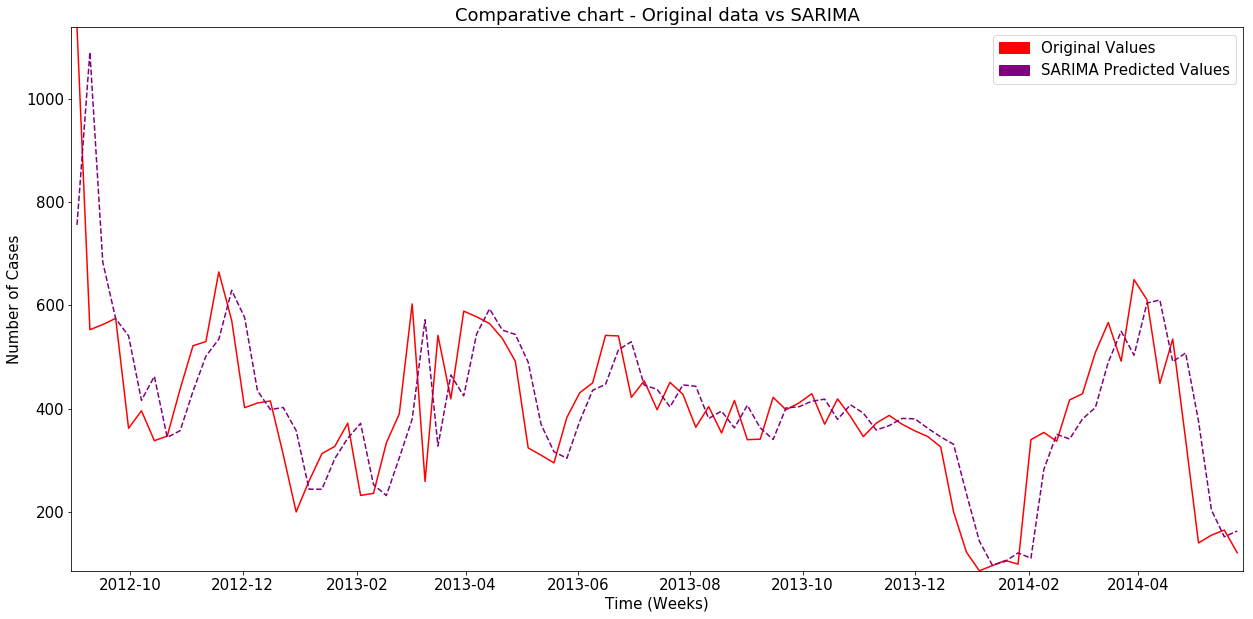

In [114]:
SARIMAX_expected, = plt.pyplot.plot(SARIMAX['Expected'], label="Original Values", color="red")
SARIMAX_predicted, = plt.pyplot.plot(SARIMAX['Predicted'], label="Predicted SARIMA Values", color='purple', linestyle='--')

original_legend = mpatches.Patch(color='red', label='Original Values')
SARIMAX_legend = mpatches.Patch(color='purple', label='SARIMA Predicted Values')

plt.pyplot.legend(handles=[original_legend, SARIMAX_legend])

plt.pyplot.xlabel('Time (Weeks)')
plt.pyplot.ylabel('Number of Cases')
plt.pyplot.title('Comparative chart - Original data vs SARIMA')

plt.pyplot.margins(0.005, 0)
#plt.pyplot.savefig('SARIMAX.eps', format='eps', dpi=1000)
plt.pyplot.savefig('SARIMAX_VS_ORIGINAL.eps', format='eps', dpi=1000)
plt.pyplot.show()

## EARS C1 VS ORIGINAL

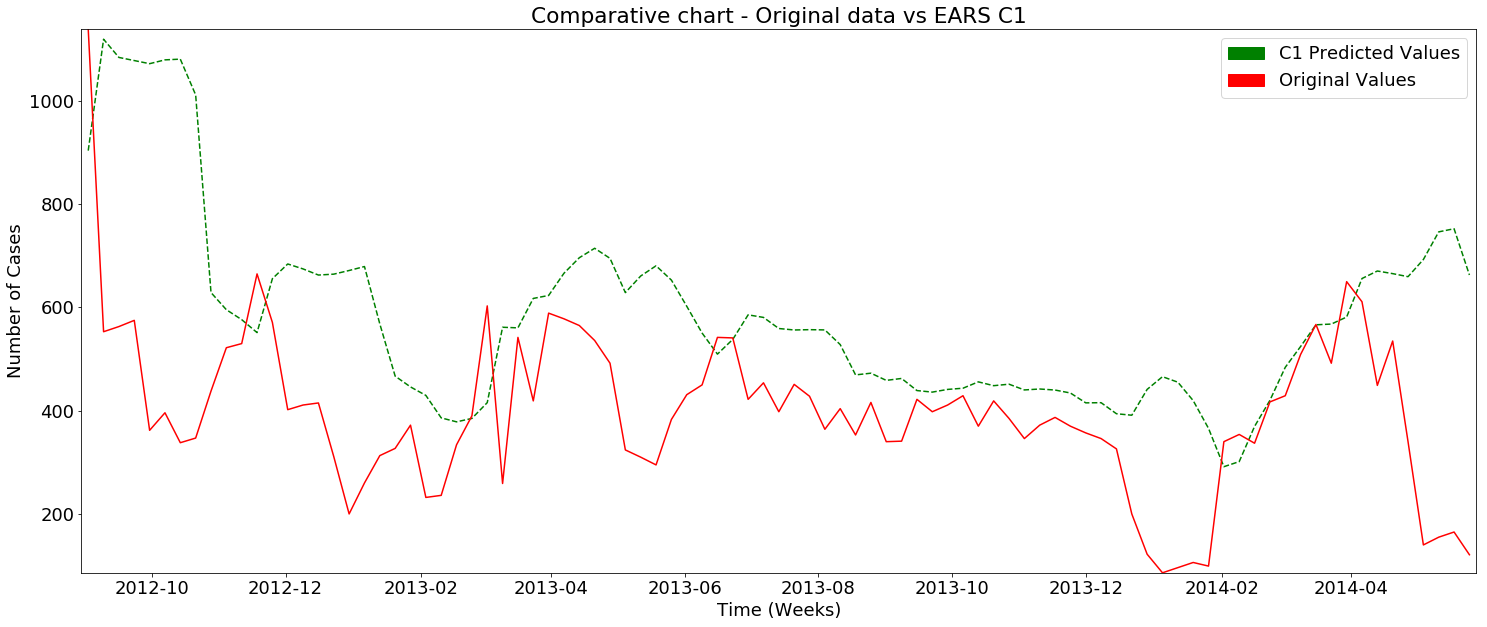

In [65]:
C1_upperbounds, = plt.pyplot.plot(C1_muestra['upperbound'], label="C1 Predicted Values", color='green', linestyle='--')
C1_observed, = plt.pyplot.plot(C1_muestra['observed'], label="C1 Observed Values", color='red')

C1_legend = mpatches.Patch(color='green', label='C1 Predicted Values')
C1_original = mpatches.Patch(color='red', label='Original Values')

plt.pyplot.legend(handles=[C1_legend, C1_original])

plt.pyplot.xlabel('Time (Weeks)')
plt.pyplot.ylabel('Number of Cases')
plt.pyplot.title('Comparative chart - Original data vs EARS C1')

plt.pyplot.margins(0.005, 0)
#plt.pyplot.savefig('SARIMAX.eps', format='eps', dpi=1000)
plt.pyplot.savefig('C1_vs_ORIGINAL.eps', format='eps', dpi=1000)
plt.pyplot.show()

## EARS C2 VS ORIGINAL

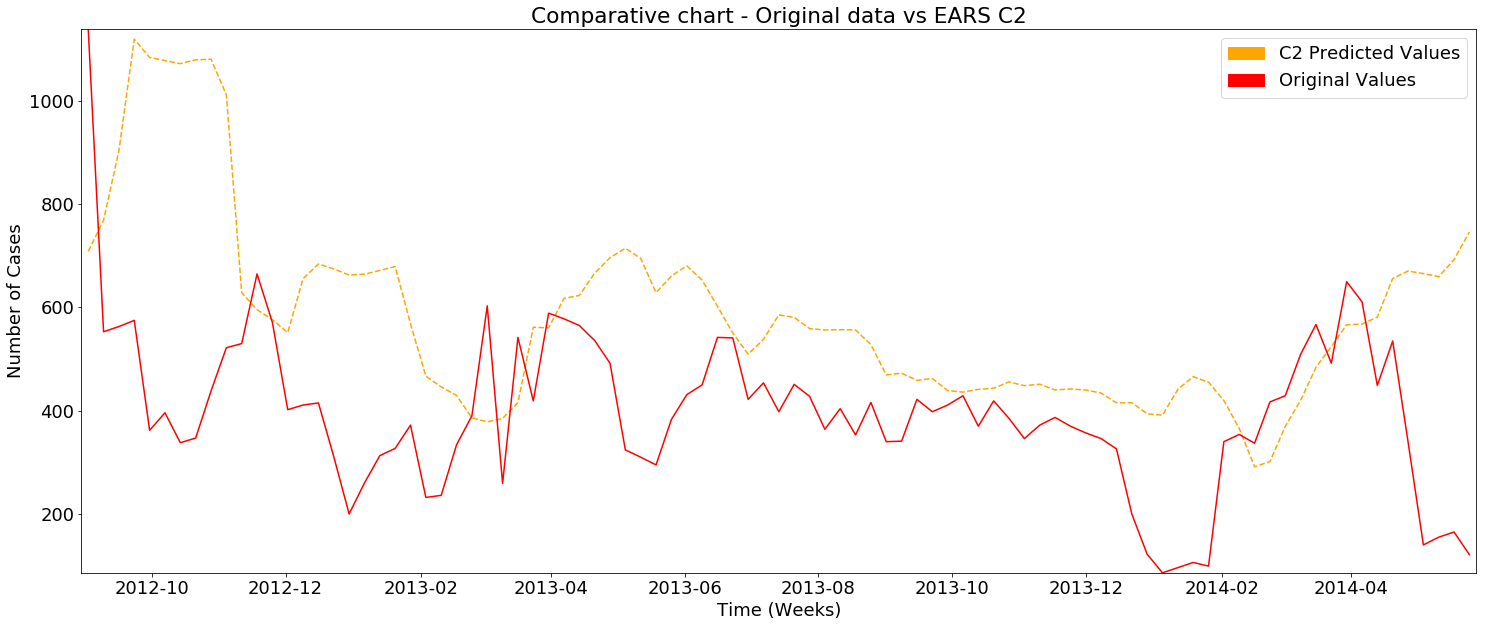

In [27]:
C2_upperbounds, = plt.pyplot.plot(C2_muestra['upperbound'], label="C2 Predicted Values", color='orange', linestyle='--')
C2_observed, = plt.pyplot.plot(C2_muestra['observed'], label="C2 Observed Values", color='red')

C2_legend = mpatches.Patch(color='orange', label='C2 Predicted Values')
C2_original = mpatches.Patch(color='red', label='Original Values')

plt.pyplot.legend(handles=[C2_legend, C2_original])

plt.pyplot.xlabel('Time (Weeks)')
plt.pyplot.ylabel('Number of Cases')
plt.pyplot.title('Comparative chart - Original data vs EARS C2')

plt.pyplot.margins(0.005, 0)
#plt.pyplot.savefig('SARIMAX.eps', format='eps', dpi=1000)
plt.pyplot.savefig('C2_vs_ORIGINAL.eps', format='eps', dpi=1000)
plt.pyplot.show()

## EARS C3 VS ORIGINAL

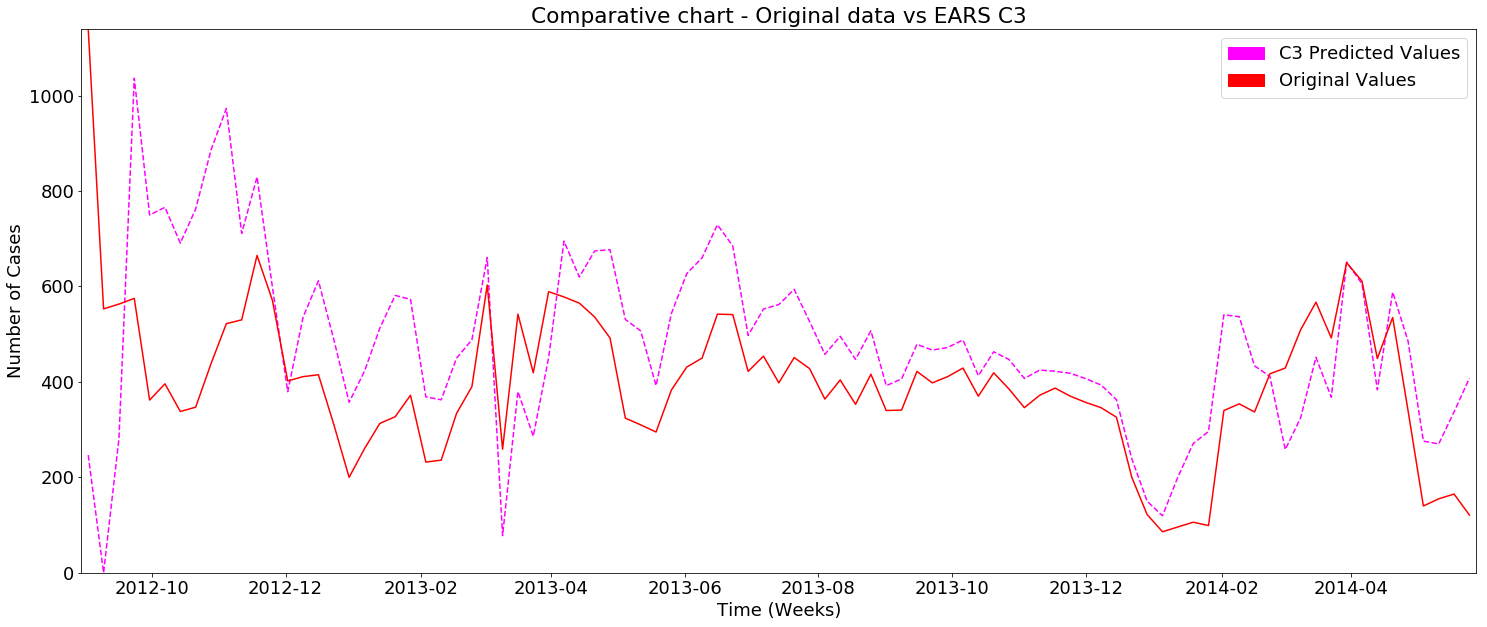

In [28]:
C3_upperbounds, = plt.pyplot.plot(C3_muestra['upperbound'], label="C3 Predicted Values", color='magenta', linestyle='--')
C3_observed, = plt.pyplot.plot(C3_muestra['observed'], label="C3 Observed Values", color='red')

C3_legend = mpatches.Patch(color='magenta', label='C3 Predicted Values')
C3_original = mpatches.Patch(color='red', label='Original Values')

plt.pyplot.legend(handles=[C3_legend, C3_original])

plt.pyplot.xlabel('Time (Weeks)')
plt.pyplot.ylabel('Number of Cases')
plt.pyplot.title('Comparative chart - Original data vs EARS C3')

plt.pyplot.margins(0.005, 0)
#plt.pyplot.savefig('SARIMAX.eps', format='eps', dpi=1000)
plt.pyplot.savefig('C3_vs_ORIGINAL.eps', format='eps', dpi=1000)
plt.pyplot.show()

## EARS (C1 C2 C3) VS ORIGINAL

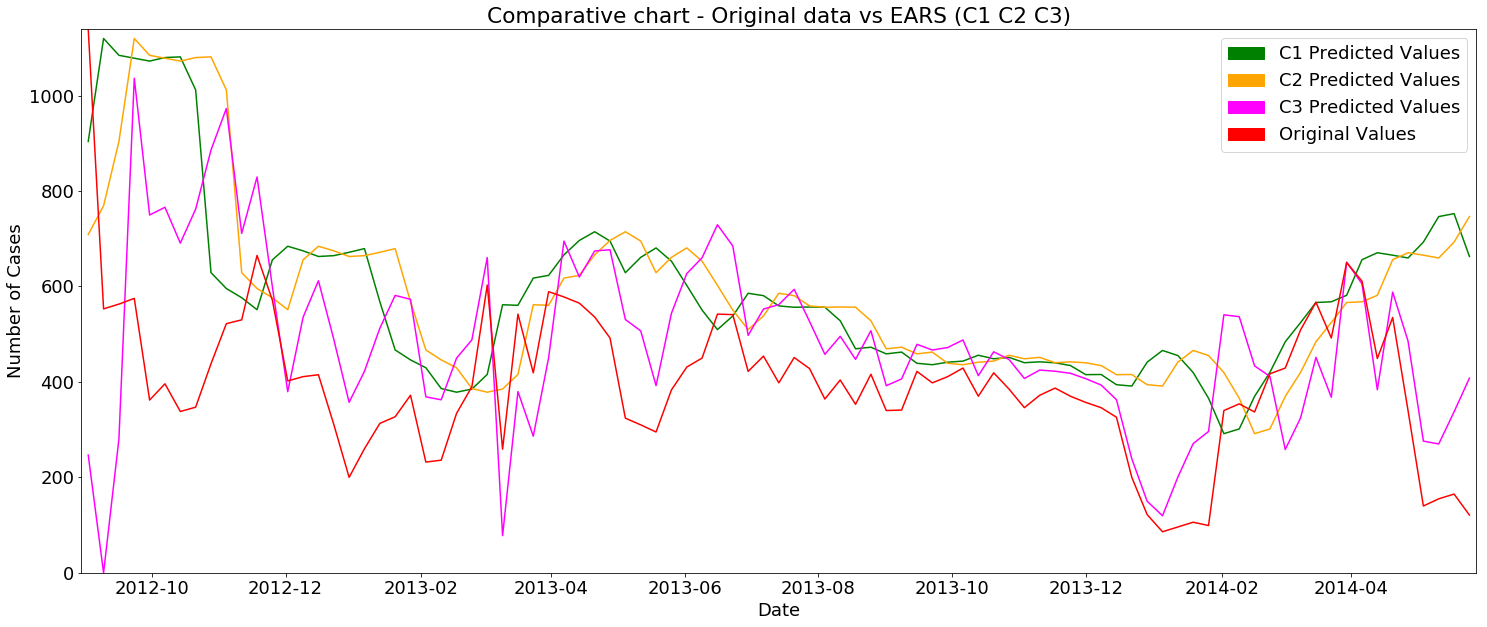

In [29]:
C1_upperbounds, = plt.pyplot.plot(C1_muestra['upperbound'], label="C1 Predicted Values", color='green')
C2_upperbounds, = plt.pyplot.plot(C2_muestra['upperbound'], label="C2 Predicted Values", color='orange')
C3_upperbounds, = plt.pyplot.plot(C3_muestra['upperbound'], label="C3 Predicted Values", color='magenta')
C3_observed, = plt.pyplot.plot(C3_muestra['observed'], label="Original Values", color='red')

_original = mpatches.Patch(color='red', label='Original Values')

plt.pyplot.legend(handles=[C1_legend, C2_legend, C3_legend, _original])

plt.pyplot.xlabel('Date')
plt.pyplot.ylabel('Number of Cases')
plt.pyplot.title('Comparative chart - Original data vs EARS (C1 C2 C3)')

plt.pyplot.margins(0.005, 0)
#plt.pyplot.savefig('SARIMAX.eps', format='eps', dpi=1000)
plt.pyplot.savefig('EARS_vs_ORIGINAL.eps', format='eps', dpi=1000)
plt.pyplot.show()

## ARIMA VS SARIMAX VS ORIGINAL VALUES

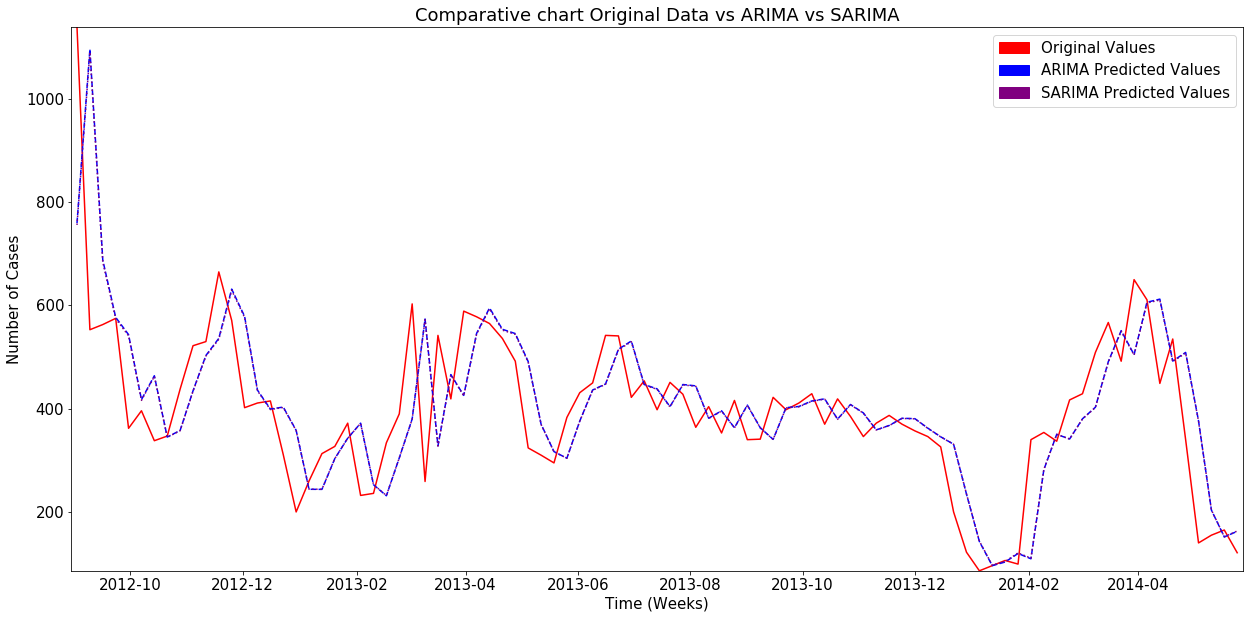

In [115]:
#Ploteo
ARIMA_expected, = plt.pyplot.plot(ARIMA['Expected'], label="Original Values", color="red")
ARIMA_predicted, = plt.pyplot.plot(ARIMA['Predicted'], label="Predicted ARIMA Values", color='blue', linestyle='--')
SARIMAX_predicted, = plt.pyplot.plot(SARIMAX['Predicted'], label="Predicted SARIMA Values", color='purple', linestyle=':')

plt.pyplot.legend(handles=[original_legend, ARIMA_legend, SARIMAX_legend])

plt.pyplot.xlabel('Time (Weeks)')
plt.pyplot.ylabel('Number of Cases')
plt.pyplot.title('Comparative chart Original Data vs ARIMA vs SARIMA')

plt.pyplot.margins(0.005, 0)
plt.pyplot.savefig('ARIMA_SARIMAX_VS_ORIGINAL.eps', format='eps', dpi=1000)
plt.pyplot.show()

## EARS VS SARIMAX VS ARIMA VS ORIGINAL

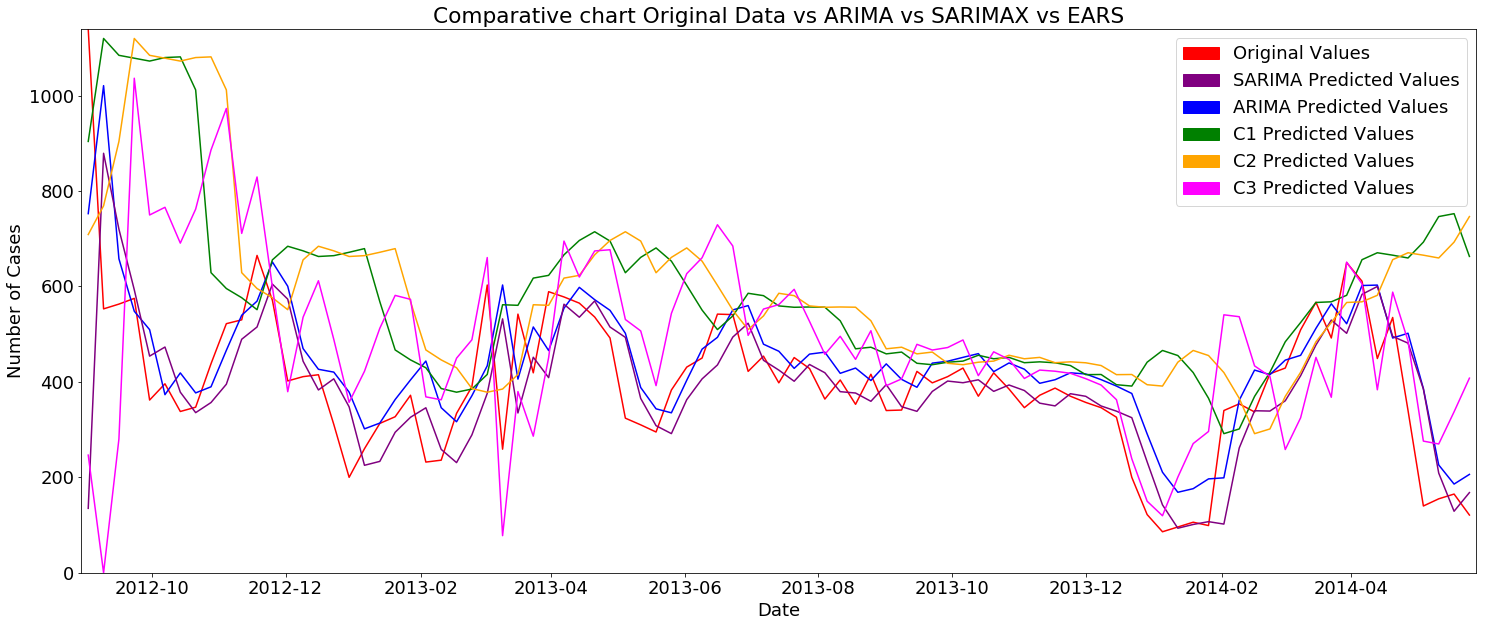

In [54]:
ARIMA_expected, = plt.pyplot.plot(ARIMA['Expected'], label="Original Values", color="red")
ARIMA_predicted, = plt.pyplot.plot(ARIMA['Predicted'], label="Predicted ARIMA Values", color='blue')
SARIMAX_predicted, = plt.pyplot.plot(SARIMAX['Predicted'], label="Predicted SARIMAX Values", color='purple')

C1_upperbounds, = plt.pyplot.plot(C1_muestra['upperbound'], label="C1 Predicted Values", color='green')
C2_upperbounds, = plt.pyplot.plot(C2_muestra['upperbound'], label="C2 Predicted Values", color='orange')
C3_upperbounds, = plt.pyplot.plot(C3_muestra['upperbound'], label="C3 Predicted Values", color='magenta')


plt.pyplot.legend(handles=[original_legend, SARIMAX_legend, ARIMA_legend, C1_legend, C2_legend, C3_legend])

plt.pyplot.xlabel('Date')
plt.pyplot.ylabel('Number of Cases')
plt.pyplot.title('Comparative chart Original Data vs ARIMA vs SARIMAX vs EARS')

plt.pyplot.margins(0.005, 0)
plt.pyplot.savefig('ARIMA_SARIMAX_EARS_VS_ORIGINAL.eps', format='eps', dpi=1000)
plt.pyplot.show()

## MAPE, MAE & MSE calculations

In [116]:
print("EARS C1 vs Original")
print("MAPE")
print(mape(C1_muestra['upperbound'], C1_muestra['observed']))
print("MAE")
print(mean_absolute_error(C1_muestra['observed'], C1_muestra['upperbound']))
print("MSE")
print(mean_squared_error(C1_muestra['observed'], C1_muestra['upperbound']))
#print(mean_absolute_percentage_error(C1_muestra['upperbound'], C1_muestra['observed']))

print("\nEARS C2 vs Original")
print("MAPE")
print(mape(C2_muestra['upperbound'], C2_muestra['observed']))
print("MAE")
print(mean_absolute_error(C2_muestra['observed'], C2_muestra['upperbound']))
print("MSE")
print(mean_squared_error(C2_muestra['observed'], C2_muestra['upperbound']))
#print(mean_absolute_percentage_error(C2_muestra['upperbound'], C2_muestra['observed']))

print("\nEARS C3 vs Original")
print("MAPE")
print(mape(C3_muestra['upperbound'], C3_muestra['observed']))
print("MAE")
print(mean_absolute_error(C3_muestra['observed'], C3_muestra['upperbound']))
print("MSE")
print(mean_squared_error(C3_muestra['observed'], C3_muestra['upperbound']))
#print(mean_absolute_percentage_error(C3_muestra['upperbound'], C3_muestra['observed']))

print("\nARIMA vs Original")
print("MAPE")
print(mape(ARIMA['Predicted'], ARIMA['Expected']))
print("MAE")
print(mean_absolute_error(ARIMA['Expected'], ARIMA['Predicted']))
print("MSE")
print(mean_squared_error(ARIMA['Expected'], ARIMA['Predicted']))
#print(mean_absolute_percentage_error(ARIMA['Predicted'], ARIMA['Expected']))

print("\nSARIMA vs Original")
print("MAPE")
print(mape(SARIMAX['Predicted'], SARIMAX['Expected']))
print("MAE")
print(mean_absolute_error(SARIMAX['Expected'], SARIMAX['Predicted']))
print("MSE")
print(mean_squared_error(SARIMAX['Expected'], SARIMAX['Predicted']))
#print(mean_absolute_percentage_error(SARIMAX['Predicted'], SARIMAX['Expected']))

EARS C1 vs Original
MAPE
78.37231322465374
MAE
201.639682675
MSE
75516.1384958

EARS C2 vs Original
MAPE
81.84545468698126
MAE
216.731389368
MSE
82219.5718706

EARS C3 vs Original
MAPE
44.98767056628118
MAE
153.255591299
MSE
41617.908126

ARIMA vs Original
MAPE
22.47366530878074
MAE
77.7549262972
MSE
13579.615107

SARIMA vs Original
MAPE
22.4184607519951
MAE
77.5258061849
MSE
13480.7325289
